In [1]:
import matplotlib.pyplot as plt
from backend import *
import numpy as np
from jax import config
config.update('jax_platform_name', 'cpu')

In [2]:
npc = 13
seed = 2020
episodes = 4999
exptname = f'1D_a2c_{npc}n_{seed}s_{episodes}e'
[logparams, allcoords, latencys] = saveload('./data/'+exptname, 1, 'load')

2024-06-17 17:12:44.239367: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [3]:
plot_place_cells(logparams[-1], startcoord=[-0.75], goalcoord=[0.5],goalsize=0.01, title='Fields after learning',envsize=1)

0.6958888261502668


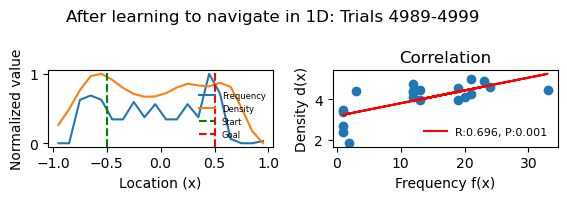

In [4]:
gap = 10
bins = 20

visits, freq, density, corr = get_1D_freq_density_corr(allcoords, logparams, end=episodes, gap=gap, bins=bins)
plot_freq_density_corr(visits, freq, density,title=f'After learning to navigate in 1D: Trials {episodes-gap}-{episodes}')

In [5]:
def get_velocity(positions, delta_t=1):
    vel = np.diff(positions,axis=0) / delta_t
    velx = get_midposition(positions)
    return vel, velx

def get_acceleration(positions, delta_t=1):
    velocities, velx = get_velocity(positions, delta_t)
    acceleration = np.diff(velocities,axis=0) / delta_t
    return acceleration, get_midposition(velx)

def get_midposition(x):
    return (x[:-1] + x[1:]) / 2

def get_pcact(params, xs):
    return np.sum(predict_batch_placecell(params, xs),axis=1)

In [8]:
gap = 10

freqs = []
vels = []
accs = []

for i in range(gap):
    trial = 4999-i
    positions = allcoords[trial][:,0]

    freq,freqx = np.histogram(positions,bins=20)
    freqx = get_midposition(freqx)

    vel, velx = get_velocity(positions)

    acc,accx = get_acceleration(positions)

    params = logparams[trial]

    print(positions.shape,freq.shape, vel.shape, acc.shape)

    freqs.append([freq, get_pcact(params, freqx)])
    vels.append([vel, get_pcact(params, velx)])
    accs.append([acc, get_pcact(params, accx)])



(19,) (20,) (18,) (17,)
(19,) (20,) (18,) (17,)
(21,) (20,) (20,) (19,)
(25,) (20,) (24,) (23,)
(19,) (20,) (18,) (17,)
(38,) (20,) (37,) (36,)
(24,) (20,) (23,) (22,)
(29,) (20,) (28,) (27,)
(24,) (20,) (23,) (22,)
(24,) (20,) (23,) (22,)


(200,) (200,)
(232,) (232,)
(222,) (222,)


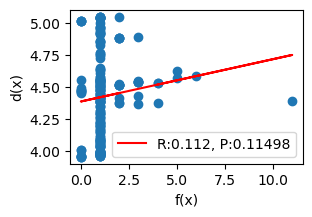

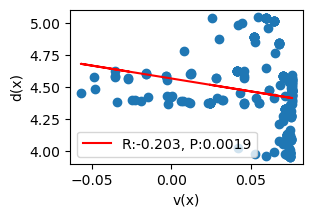

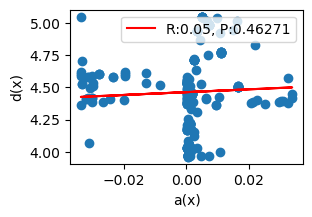

In [9]:
names = ['f(x)','v(x)','a(x)']
for i,vars in enumerate([freqs, vels, accs]):
    var = np.concatenate([pair[0] for pair in vars])
    pc = np.concatenate([pair[1] for pair in vars])
    print(var.shape, pc.shape)
    R = np.corrcoef(var,pc)[0,1]

    plt.figure(figsize=(3,2))
    plt.scatter(var, pc)
    plt.xlabel(names[i])
    plt.ylabel('d(x)')
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(var).reshape(-1), np.array(pc).reshape(-1))
    regression_line = slope * np.array(var).reshape(-1) + intercept
    plt.plot(np.array(var).reshape(-1), regression_line, color='red', label=f'R:{np.round(r_value,3)}, P:{np.round(p_value,5)}')
    plt.legend()